<a href="https://colab.research.google.com/github/sokrypton/ColabBio/blob/main/notebooks/upgma_nj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dm = [[  0, 32, 48, 51, 50, 48, 98,148],
      [ 32,  0, 26, 34, 29, 33, 84,136],
      [ 48, 26,  0, 42, 44, 44, 92,152],
      [ 51, 34, 42,  0, 44, 38, 86,142],
      [ 50, 29, 44, 44,  0, 24, 89,142],
      [ 48, 33, 44, 38, 24,  0, 90,142],
      [ 98, 84, 92, 86, 89, 90,  0,148],
      [148,136,152,142,142,142,148,  0]]

labels = ["Dog","Bear","Raccoon","Weasel","Seal","SeaLion","Cat","Monkey"]

In [ ]:
def get_NJ(X, upgma=False, nw=True, nw_labels=None, nw_parent=False):
  '''
  given distance matrix, return tree
  --------------------------------------------------------
  - X:         input distance matrix
  - upgma:     [True/False] do upgma instead of neighbor joining
  ----------------------------------------------------------------
  - nw:        [True/False] return newick string
  - nw_labels: use provided labels
  - nw_parent: [True/False] label parent nodes in newick string
  ----------------------------------------------------------------
  '''
  def min_idx(q):
    '''given symmetric matrix, return indices of smallest value'''
    i = np.triu_indices_from(q,1)
    i_min = np.argmin(q[i])
    return [j[i_min] for j in i]

  dm = np.array(X)          # distance matrix
  L = dm.shape[0]           # num of nodes
  nodes = np.arange(L)      # list of nodes
  adj = [None] * (L-1) * 2  # adj. table

  if upgma:
    # keep track of total distances accounted for
    dist_to_tip = np.zeros(L)

  if nw:
    # initialize newick-string
    if nw_labels is None: nw_labels = nodes.astype(np.str)
    else: nw_labels = np.array(nw_labels)

  # build tree
  for n in range(L-1):
    # new parent node
    parent_node = n + L

    if upgma:
      # indices of min(dm matrix)
      idx = min_idx(dm)

      # compute branch lengths
      branch_len_avg = dm[idx[0],idx[1]]/2

      # substract distance already accounted for
      branch_len_0, branch_len_1 = branch_len_avg - dist_to_tip[idx]

    else:
      # compute q matrix
      dm_len = dm.shape[0]-2
      dm_sum = dm.sum(0)
      q = (dm_len * dm) - dm_sum[None,:] - dm_sum[:,None]

      # indices of min(q matrix)
      idx = min_idx(q)

      # compute branch lengths
      branch_len_avg = dm[idx[0],idx[1]]/2
      if dm_len == 0:
        branch_len_0 = branch_len_1 = branch_len_avg
      else:
        y = dm_sum[idx]/(2*dm_len)
        branch_len_0 = branch_len_avg + (y[0] - y[1])
        branch_len_1 = branch_len_avg + (y[1] - y[0])

    # update adj. table
    child_node_0, child_node_1 = nodes[idx]
    adj[child_node_0] = [child_node_0, parent_node, branch_len_0]
    adj[child_node_1] = [child_node_1, parent_node, branch_len_1]

    # update newick string
    if nw:
      nw_labels_ = f"({nw_labels[idx[0]]}:{branch_len_0},"
      nw_labels_ += f"{nw_labels[idx[1]]}:{branch_len_1})"
      if nw_parent: nw_labels_ += f"p{parent_node}"
      nw_labels = np.append(np.delete(nw_labels,idx),nw_labels_)

    # del children nodes, add parent node
    nodes = np.append(np.delete(nodes,idx),parent_node)

    ###############
    ## UPDATE DM ##
    ###############

    # add parent
    parent_dist = dm[idx].mean(0,keepdims=True)
    if upgma: dist_to_tip = np.append(np.delete(dist_to_tip, idx), branch_len_avg)
    else: parent_dist -= branch_len_avg
    dm = np.append(dm,parent_dist,0) # add row
    dm = np.append(dm,np.append(parent_dist,0)[:,None],1) # add col

    # del children
    dm = np.delete(dm,idx,0) # del row
    dm = np.delete(dm,idx,1) # del col

  if nw: return adj, nw_labels[0]
  else: return adj

In [ ]:
adj, nw = get_NJ(dm, upgma=True, nw_labels=labels)

In [ ]:
!pip -q install biopython
from Bio import Phylo
from io import StringIO

     |████████████████████████████████| 2.3MB 2.7MB/s 


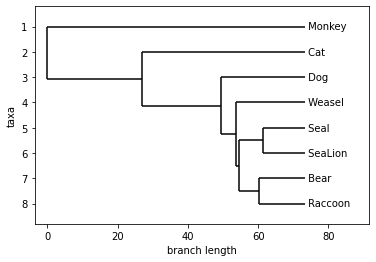

In [ ]:
tree = Phylo.read(StringIO(nw), "newick")
Phylo.draw(tree)

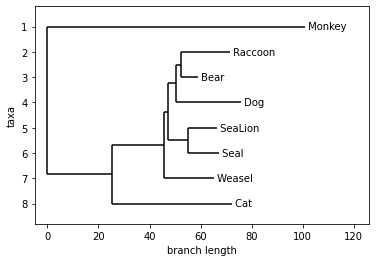

In [ ]:
# with neighbor-joining
adj, nw = get_NJ(dm, upgma=False, nw_labels=labels)
tree = Phylo.read(StringIO(nw), "newick")
tree.root_at_midpoint()
Phylo.draw(tree)

## EXTRACT tip-to-tip distances

In [ ]:
def get_DM(adj):
  '''
  given adjacency table, return distance matrix
  '''
  num_branches = len(adj)
  num_tips = int(num_branches/2) + 1

  # for each tip, compute distance to each ancestor
  def get_ancestors(n):
    '''
    - input: tip id
    - output: list(ancestor id), list(dist. to ancestor)
    '''
    dist,N,D = 0,[],[]
    while n < num_branches:
      _,n,branch_len = adj[n]
      dist += branch_len
      N.append(n)
      D.append(dist)
    return N,D

  ancestors = [get_ancestors(i) for i in range(num_tips)]

  # for each pair of tips, add distance to common ancestor
  DM = np.zeros((num_tips, num_tips))
  for i in range(num_tips):
    ni,di = ancestors[i]
    for j in range(i+1,num_tips):
      nj,dj = ancestors[j]
      # find common ancestor
      a,b = 0,0
      while True:
        if ni[a] < nj[b]: a += 1
        elif nj[b] < ni[a]: b += 1
        else: break
      # add distances to ancestor
      DM[i,j] = di[a] + dj[b]

  return DM + DM.T

In [ ]:
dm_fix = get_DM(adj)

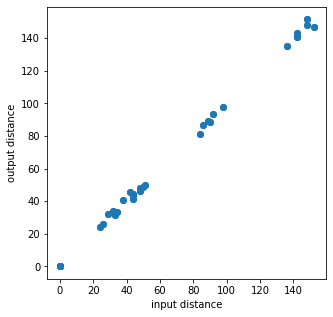

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(dm,dm_fix)
plt.xlabel("input distance")
plt.ylabel("output distance")
plt.show()